# Comparing two segmentation models

SAM-HQ: https://github.com/SysCV/sam-hq

MobileSAMv2: https://github.com/ChaoningZhang/MobileSAM

In [39]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Set image and load

In [11]:
image_fn = '/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/preproc/images/frame_00001.png'
image_fn = Path(image_fn)
image = cv2.imread(image_fn.as_posix())

### Download SAM-HQ weights

In [ ]:
!mkdir /workspace/collab-environment/ckpts/
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth /workspace/collab-environment/ckpts/sam_hq_vit_l.pth

### Load SAM-HQ model

SAM HQ is better at segmenting fine-grained structures

In [6]:
%load_ext autoreload
%autoreload 2
from segment_anything_hq import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_l"
sam_checkpoint = f"/workspace/collab-environment/ckpts/sam_hq_{model_type}.pth"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<All keys matched successfully>


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Pass through mask generator

In [36]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25,  # Requires open-cv to run post-processing
)
masks = mask_generator.generate(image)

Examine masks

SAM HQ generated 393 masks


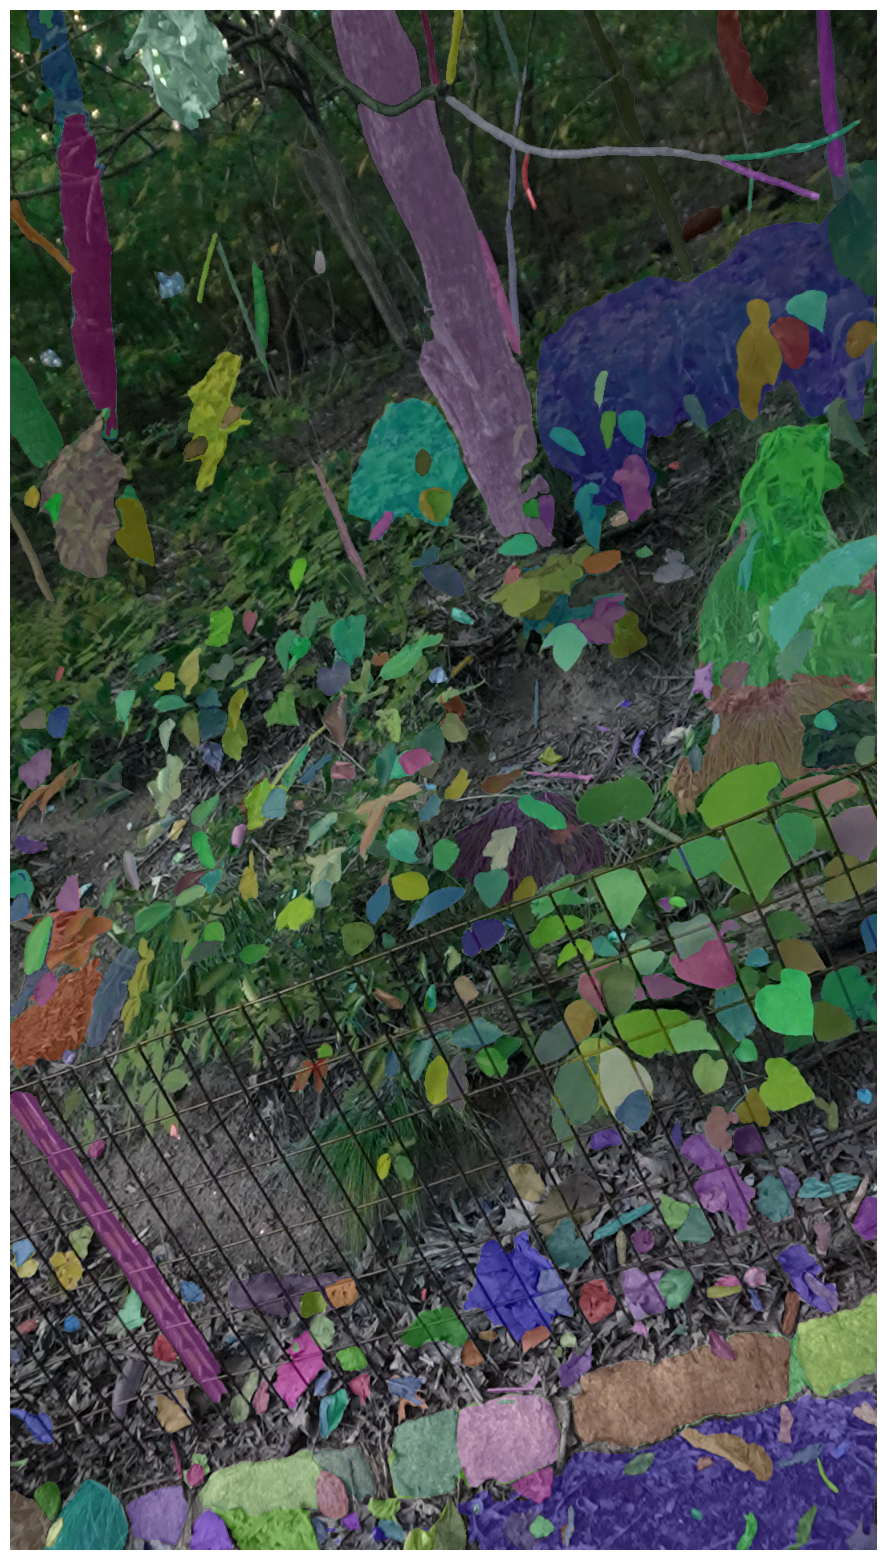

In [37]:
print (f"SAM HQ generated {len(masks)} masks")

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Compare to MobileSAMv2

SAMv2 should win out here

Requires installation of MobileSAM: ```python3 -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git```

In [40]:
mobilesamv2_encoder_name: str = 'mobilesamv2_efficientvit_l2'
mobilesamv2, ObjAwareModel, predictor = torch.hub.load("RogerQi/MobileSAMV2", mobilesamv2_encoder_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
mobilesamv2.to(device=device)
mobilesamv2.eval()

Using cache found in /workspace/models/hub/RogerQi_MobileSAMV2_main


checkpoint_load_scucess


Sam(
  (image_encoder): EfficientViTSamImageEncoder(
    (backbone): EfficientViTLargeBackbone(
      (stages): ModuleList(
        (0): OpSequential(
          (op_list): ModuleList(
            (0): ConvLayer(
              (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (norm): BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
              (act): GELU(approximate='tanh')
            )
            (1): ResidualBlock(
              (main): ResBlock(
                (conv1): ConvLayer(
                  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (norm): BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
                  (act): GELU(approximate='tanh')
                )
                (conv2): ConvLayer(
                  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [46]:
from mobile_sam import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(
    model=mobilesamv2,
    points_per_side=32,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10,  # Requires open-cv to run post-processing
)
masks = mask_generator.generate(image)

Examine masks

MobileSAMv2 generated 454 masks


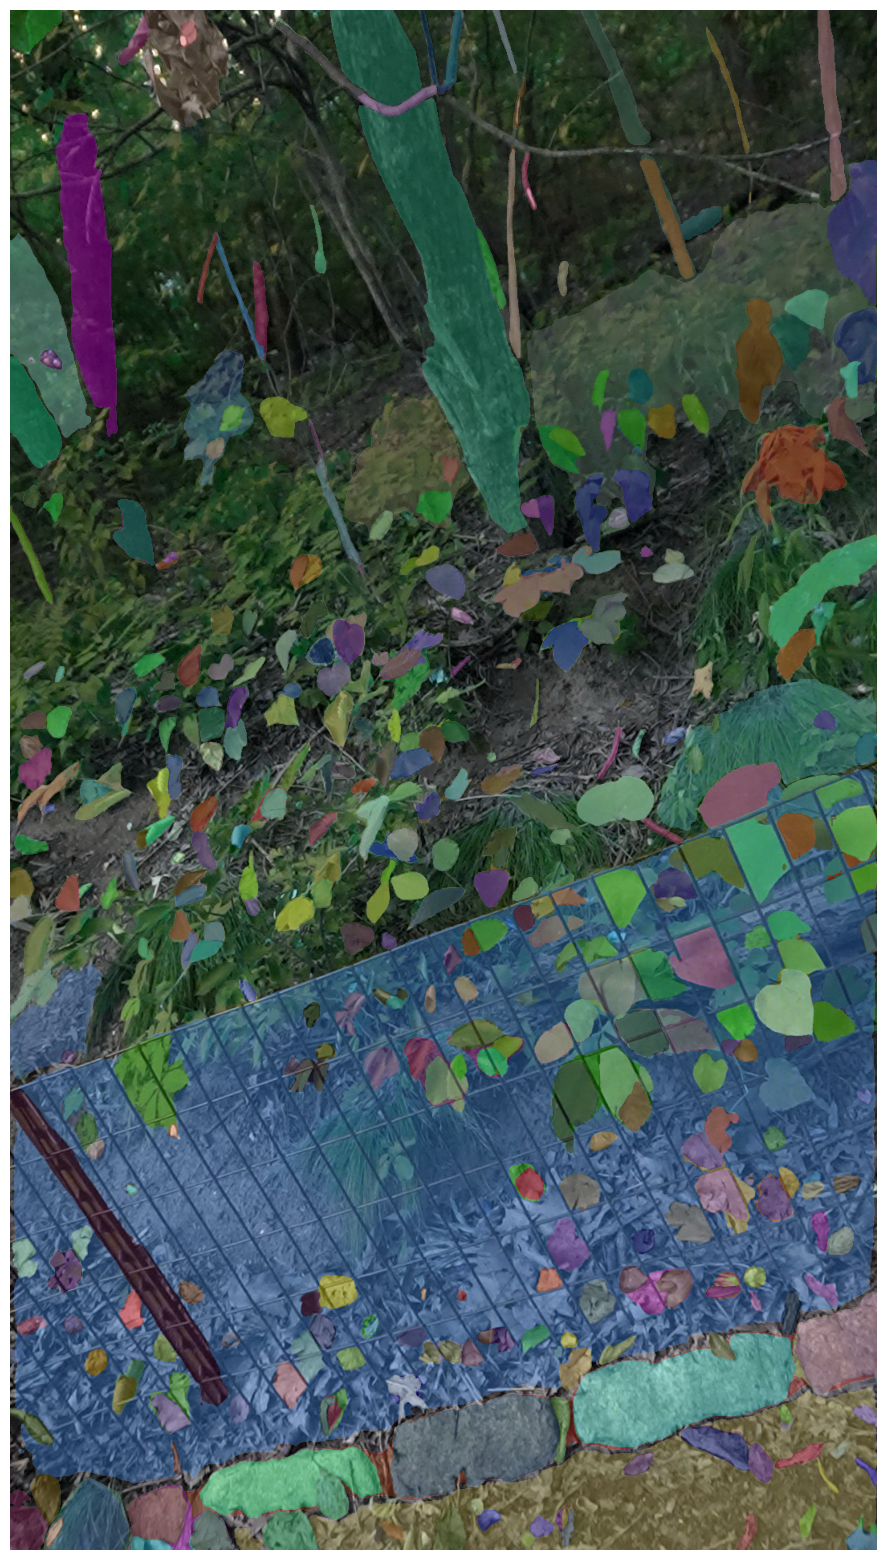

In [47]:
print (f"MobileSAMv2 generated {len(masks)} masks")

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 